ctrl shift f10 - search commands

In [ ]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib


In [2]:
from tensorflow import keras
from tensorflow.keras import activations, regularizers, layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('TPU')))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  0


In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
filetype = "Segmented"
numcode = 1
plant = "Apple"

# Getting the data

terminate session - ram disk 3 dots, manage session, terminate

In [6]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [7]:
!unzip '/content/gdrive/MyDrive/Plants Project/Plants_T_GHL'

Streaming output truncated to the last 5000 lines.
  inflating: Plants_T_GHL/Train/Apple/Apple scab/66__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/67__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/68__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/69__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/7__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/70__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/71__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/72__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/73__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/74__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/75__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/76__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/

# temp - count

In [8]:
xpath = '/content/Plants_T_GHL/Train/'+ plant + '/Healthy/'
data_dir = pathlib.Path(xpath)
print(len(list(data_dir.glob('*'))))


380


In [9]:
xpath = '/content/Plants_T_GHL/Train/'

In [10]:
import os
c = 0
for folder, subfolders, filenames in os.walk(xpath):
    c += len(filenames)
print(c)

5320


# Some functions

In [11]:
def get_label(file_path, class_names):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The fourth to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)



In [12]:
def decode_img(img, img_height, img_width):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


In [13]:
def process_path(file_path):
  label = get_label(file_path, class_names)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img, img_height, img_width)
  return img, label


In [14]:
def getfiles(srcpath):
  lfiles = []
  for fol, subfol, files in os.walk(srcpath):
    for file in files:
      lfiles.append(os.path.join(srcpath, os.path.relpath(file)))
  return lfiles

In [15]:
def getinput(src, image_count):
  list_ds = tf.data.Dataset.list_files(str(src), shuffle=True)
  list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)
  val_size = int(image_count * 0.2)
  print(src, 'val size', val_size)
  train_ds = list_ds.skip(val_size)
  val_ds = list_ds.take(val_size)
  print(src, '# train', tf.data.experimental.cardinality(train_ds).numpy())
  print(src, '# test', tf.data.experimental.cardinality(val_ds).numpy())


In [16]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [17]:
def pred(imgpath):
  img = tf.keras.utils.load_img(
      os.path.abspath(imgpath), target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = head_model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  # print(
  #     " {} with a {:.2f} percent confidence."
  #     .format(class_names[np.argmax(score)], 100 * np.max(score))
  # )
  return class_names[np.argmax(score)]

In [18]:
def test_acc(srcpath, classlabel):
  c = 0
  for i in srcpath:
    # print(i, pred(i))
    if classlabel == pred(i):
      c += 1
  return c

# Some parameters

In [19]:
batch_size = 32
img_height = 180
img_width = 180


In [20]:
xpath = '/content/Plants_T_GHL/Train/'+ plant + "/"
data_dir = pathlib.Path(xpath)
print(len(list(data_dir.glob('*'))))
print(data_dir)

3
/content/Plants_T_GHL/Train/Apple


# Preparing data

In [21]:
image_count = 380 * 4
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=True)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)

In [22]:
for f in list_ds.take(5):
  print(f.numpy())


b'/content/Plants_T_GHL/Train/Apple/Black rot/114__Apple__Black rot.JPG'
b'/content/Plants_T_GHL/Train/Apple/Black rot/206__Apple__Black rot.JPG'
b'/content/Plants_T_GHL/Train/Apple/Healthy/114__Apple__Healthy.JPG'
b'/content/Plants_T_GHL/Train/Apple/Apple scab/56__Apple__Apple scab.JPG'
b'/content/Plants_T_GHL/Train/Apple/Apple scab/36__Apple__Apple scab.JPG'


In [23]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)


['Apple scab' 'Black rot' 'Healthy']


In [24]:
print(image_count, image_count*0.2 )

1520 304.0


In [25]:
val_size = int(image_count * 0.2)
print(val_size)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)


304


In [26]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.SkipDataset'>


In [27]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


836
304


# Standardize the data

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# total_ds = temp_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [29]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(buffer_size= image_count )
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [30]:
height_factor = [0, 0.1] # between 20%, 30%
width_factor = [0, 0.1]
layer_zoom = tf.keras.layers.RandomZoom(
    height_factor, width_factor=None, fill_mode='reflect',
    interpolation='bilinear', seed=None, fill_value=0.0
)
train_ds = train_ds.map(lambda x, y: (layer_zoom(x), y))
val_ds = val_ds.map(lambda x, y: (layer_zoom(x), y))

factor = [0, 0.05]
layer_rot = tf.keras.layers.RandomRotation(
    factor, fill_mode='reflect', interpolation='bilinear',
    seed=None, fill_value=0.0
)
train_ds = train_ds.map(lambda x, y: (layer_rot(x), y))
val_ds = val_ds.map(lambda x, y: (layer_rot(x), y))



In [31]:
layer_train = tf.keras.layers.experimental.preprocessing.Normalization(axis=None)
train_ds = train_ds.map(lambda x, y: (layer_train(x), y))
# train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (layer_train(x), y))
# val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


In [32]:
for image, label in train_ds.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2
Image shape:  (180, 180, 3)
Label:  2
Image shape:  (180, 180, 3)
Label:  0
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  1


# Model

In [33]:
base_model = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False, weights='imagenet', classes=class_names, input_shape = (img_height, img_width, 3)
)

115277824/115263384 [==============================] - 3s 0us/step


In [34]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(len(class_names), activation = 'softmax')(x)

head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [35]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

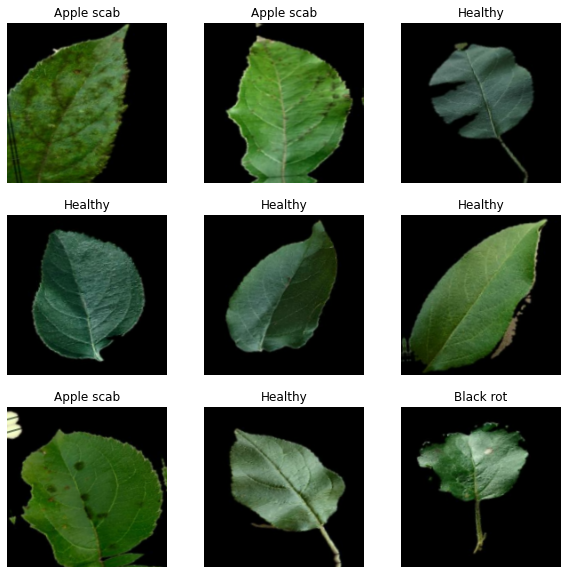

In [36]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")


# Train

In [37]:
epochs=25
history = head_model.fit(train_ds, batch_size = batch_size, epochs=epochs, validation_data=val_ds)


Epoch 1/25
27/27 [==============================] - 61s 1s/step - loss: 2.7783 - accuracy: 0.8493 - val_loss: 1.4439 - val_accuracy: 0.8849
Epoch 2/25
27/27 [==============================] - 20s 736ms/step - loss: 0.5415 - accuracy: 0.9127 - val_loss: 211.8900 - val_accuracy: 0.7796
Epoch 3/25
27/27 [==============================] - 20s 744ms/step - loss: 0.1026 - accuracy: 0.9581 - val_loss: 37.5401 - val_accuracy: 0.8717
Epoch 4/25
27/27 [==============================] - 20s 756ms/step - loss: 0.6117 - accuracy: 0.9545 - val_loss: 191.2841 - val_accuracy: 0.7270
Epoch 5/25
27/27 [==============================] - 20s 758ms/step - loss: 10.6647 - accuracy: 0.9294 - val_loss: 827.2270 - val_accuracy: 0.6316
Epoch 6/25
27/27 [==============================] - 21s 770ms/step - loss: 0.5328 - accuracy: 0.8971 - val_loss: 12.8438 - val_accuracy: 0.8092
Epoch 7/25
27/27 [==============================] - 20s 759ms/step - loss: 0.3919 - accuracy: 0.9234 - val_loss: 0.4421 - val_accuracy: 

In [38]:
len(head_model.history.history['accuracy'])

25

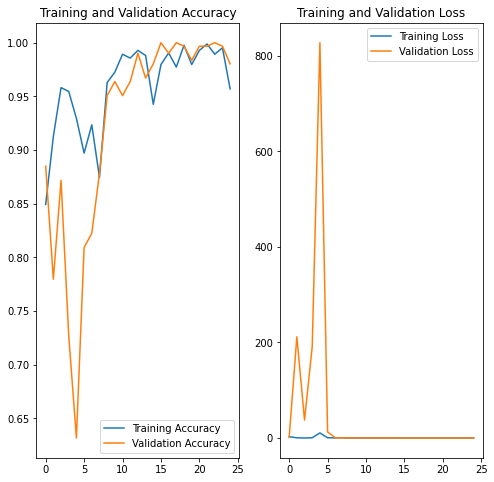

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = range(len(head_model.history.history['accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [40]:
print(acc, val_acc)

[0.8492823243141174, 0.9126794338226318, 0.9581339955329895, 0.9545454382896423, 0.929425835609436, 0.8971291780471802, 0.9234449863433838, 0.8744019269943237, 0.9629186391830444, 0.9724880456924438, 0.989234447479248, 0.9856459498405457, 0.9928229451179504, 0.9880383014678955, 0.9425837397575378, 0.9796651005744934, 0.9904305934906006, 0.9772727489471436, 0.9976076483726501, 0.9796651005744934, 0.9928229451179504, 0.9988038539886475, 0.989234447479248, 0.9952152967453003, 0.9569377899169922] [0.8848684430122375, 0.7796052694320679, 0.8717105388641357, 0.7269737124443054, 0.6315789222717285, 0.8092105388641357, 0.8223684430122375, 0.8782894611358643, 0.9506579041481018, 0.9638158082962036, 0.9506579041481018, 0.9638158082962036, 0.9901315569877625, 0.9671052694320679, 0.9802631735801697, 1.0, 0.9901315569877625, 1.0, 0.9967105388641357, 0.9835526347160339, 0.9967105388641357, 0.9967105388641357, 1.0, 0.9967105388641357, 0.9802631735801697]


In [ ]:
# import pickle

# with open("/content/gdrive/MyDrive/Project Final year/"+ plant + "_efficientNet_"+str(numcode) + "_"+str(img_width) + 'x' + str(img_height)  +".pkl", "wb") as file:
#   pickle.dump(head_model, file)

In [41]:
head_model.save('/content/gdrive/MyDrive/Apple_1.h5')
head_model.save_weights('/content/gdrive/MyDrive/Apple/checkpoints/Apple_1')

# Test

In [42]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['Apple scab' 'Black rot' 'Healthy']


In [43]:
base_model = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False, weights='imagenet', classes=class_names, input_shape = (img_height, img_width, 3)
)

In [44]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(len(class_names), activation = 'softmax')(x)

head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
head_model.load_weights('/content/gdrive/MyDrive/Apple/checkpoints/Apple_1')

In [45]:
tpath = '/content/Plants_T_GHL/Test/Apple/Apple scab/418__Apple__Apple scab.JPG'
img = tf.keras.utils.load_img(
    tpath, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = head_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to Apple scab with a 57.58 percent confidence.


In [ ]:
# head_model = None
# with open("/content/gdrive/MyDrive/Project Final year/" + plant + "_efficientNet_"+str(numcode)+ "_"+str(img_width) + 'x' + str(img_height) +".pkl", "rb") as file:
#   model = pickle.Unpickler(file)
#   global head_model
#   head_model = model.load()

In [ ]:
# print(score)

In [46]:
diseases = ['Apple scab', 'Black rot', 'Healthy']
imgtypes = [ plant ]
# imgtypes = ['Color', 'GrayScale', 'Segmented']
filesdict = {}
for disease in diseases:
  for imgtype in imgtypes:
      srcpath = os.path.join(r'/content/Plants_T_GHL/Test', imgtype+ "/"+disease)
      print(getfiles(srcpath))
      filesdict[disease+imgtype] = [disease, getfiles(srcpath)]

['/content/Plants_T_GHL/Test/Apple/Apple scab/412__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/391__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/385__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/389__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/384__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/395__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/400__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/390__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/415__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/406__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/399__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/420__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/Apple scab/388__Apple__Apple scab.JPG', '/content/Plants_T_GHL/Test/Apple/App

In [47]:
for k, v in filesdict.items():
  count_ = test_acc(v[1], v[0])
  print(k, count_, count_/len(v[1]))

Apple scabApple 33 0.825
Black rotApple 39 0.975
HealthyApple 40 1.0


In [48]:
# imgtypes = ['Color', 'GrayScale', 'Segmented']
imgtypes = [ plant ]
filesdict = {}
for imgtype in imgtypes:
  srcpath = os.path.join(r'/content/Plants_T_GHL/Test', imgtype+"//Healthy")
  filesdict[imgtype] = [disease, getfiles(srcpath)]
for k, v in filesdict.items():
  count_ = test_acc(v[1], "Healthy")
  print(k, count_, count_/len(v[1]))

Apple 40 1.0
